In [1]:
import re
from urllib.request import urlopen

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print
from scipy import stats
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm

%load_ext rich

pd.set_option("display.max_columns", None)

# Problem Statement

How does Airbnb listing prices depend on the listing details? In other words, given the details of a listing, can we predict its price?

### Dataset
The dataset has been downloaded from [Inside Airbnb](http://insideairbnb.com/get-the-data.html). It contains information about Airbnb listings in Montreal, QC. The data has been downloaded for multiple months and de-duplicated to create a single dataset.

### Results
The expected outcome is a model that can predict the price of a listing given its details. The model should be able to predict the price of a new listing that is not in the dataset, which can be used by Airbnb hosts to set the price of their listing.

# Download and load data


In [2]:
def load_data():
    """ """
    df = pd.DataFrame()
    filelist = [
        "2023-11-13",
        "2023-10-08",
        "2023-09-02",
        "2023-08-12",
        "2023-07-10",
        "2023-06-10",
    ]

    for file in tqdm(filelist):
        try:
            url = (
                "http://data.insideairbnb.com/canada/qc/montreal/"
                + file
                + "/data/listings.csv.gz"
            )

            resp = urlopen(url)
            df_temp = pd.read_csv(resp, compression="gzip")

            df = pd.concat([df, df_temp], axis=0, ignore_index=True)
            # For the records from the same id, we take the newer record
            df = df[~df.id.duplicated()]
        except Exception as e:
            print(file, " fail")

    df.to_csv("data/montreal_listings.csv", index=False)

    return df.reset_index(drop=True)


# Run this line to download the data
# df = load_data()

In [3]:
df = pd.read_csv("./data/montreal_listings.csv")

<ipython-input-3-a3b1cdc510dc>:1: DtypeWarning: Columns (6,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/montreal_listings.csv")


## Quick look at the data


In [4]:
df.shape

(12085, 75)

In [5]:
df.sample(5, random_state=42)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
7037,928219141773921879,https://www.airbnb.com/rooms/928219141773921879,20231113212010,2023-11-23,city scrape,Condo in Montréal · 2 bedrooms · 2 beds · 1 bath,NaN,South-West near Atwater Market and Lionel Grou...,https://a0.muscache.com/pictures/prohost-api/H...,195649860,https://www.airbnb.com/users/show/195649860,Jean-Christoph,2018-06-14,"Montreal, Canada","Depuis plus de 20 ans, RAGQ vous aide à trouve...",within an hour,94%,62%,f,https://a0.muscache.com/im/pictures/user/3d597...,https://a0.muscache.com/im/pictures/user/3d597...,Pont-Viau,94,184,"['email', 'phone']",t,t,"Montréal, Quebec, Canada",Le Sud-Ouest,NaN,45.480879,-73.584168,Entire condo,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Washer"", ""Oven"", ""Dishwasher"", ""Bed linens"",...",$103.00,130,365,31,31,365,365,31.0,365.0,NaN,t,0,0,21,296,2023-11-23,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,85,85,0,0,NaN
11950,859440942995538600,https://www.airbnb.com/rooms/859440942995538600,20230610213107,2023-06-11,city scrape,Condo in Montréal · ★4.92 · Studio · 1 bed · 1...,Welcome to Montreal’s best location and friend...,The area is also amazing and hugely popular am...,https://a0.muscache.com/pictures/prohost-api/H...,507948358,https://www.airbnb.com/users/show/507948358,Cher,2023-03-31,NaN,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/cf683...,https://a0.muscache.com/im/pictures/user/cf683...,NaN,11,14,['phone'],t,t,"Montréal, Quebec, Canada",Mercier-Hochelaga-Maisonneuve,NaN,45.539490,-73.540997,Entire condo,Entire home/apt,3,NaN,1 bath,NaN,1.0,"[""Portable fans"", ""Baking sheet"", ""Free street...",$209.00,1,365,1,1,365,365,1.0,365.0,NaN,t,30,60,90,179,2023-06-11,13,13,8,2023-04-08,2023-06-05,4.92,4.69,4.85,4.77,4.92,4.69,4.69,221748,t,11,11,0,0,6.00
6951,920662157919198069,https://www.airbnb.com/rooms/920662157919198069,20231113212010,2023-11-23,city scrape,Home in Montréal · 2 bedrooms · 4 beds · 1.5 b...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,99067482,https://www.airbnb.com/users/show/99067482,Marylu,2016-10-10,"Montreal, Canada",I'm a young woman who likes to travel and love...,within a day,67%,20%,f,https://a0.muscache.com/im/pictures/user/6673f...,https://a0.muscache.com/im/pictures/user/6673f...,NaN,1,2,"['email', 'phone']",t,t,NaN,Mercier-Hochelaga-Maisonneuve,NaN,45.608180,-73.532146,Private room in home,Private room,4,NaN,1.5 baths,2.0,4.0,"[""Washer"", ""First aid kit"", ""Free parking on p...",$200.00,31,365,31,31,365,365,31.0,365.0,NaN,t,30,60,90,360,2023-11-23,1,1,0,2023-08-05,2023-08-05,5.00,5.00,4.00,5.00,5.00,4.00,5.00,NaN,f,1,0,1,0,0.27
7753,978220673933948766,https://www.airbnb.com/rooms/978220673933

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12085 entries, 0 to 12084
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            12085 non-null  int64  
 1   listing_url                                   12085 non-null  object 
 2   scrape_id                                     12085 non-null  int64  
 3   last_scraped                                  12085 non-null  object 
 4   source                                        12085 non-null  object 
 5   name                                          12085 non-null  object 
 6   description                                   3672 non-null   object 
 7   neighborhood_overview                         6094 non-null   object 
 8   picture_url                                   12085 non-null  object 
 9   host_id                                       12085 non-null 

Since there are a lot of spurious column that are not useful for our analysis, we will drop them before proceeding further.


In [7]:
df.columns


Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'c

In [8]:
cols_to_drop = [
    "listing_url",
    "scrape_id",
    "last_scraped",
    "picture_url",
    "host_thumbnail_url",
    "host_picture_url",
    "neighbourhood_group_cleansed",
    "minimum_minimum_nights",
    "maximum_minimum_nights",
    "minimum_maximum_nights",
    "maximum_maximum_nights",
    "minimum_nights_avg_ntm",
    "maximum_nights_avg_ntm",
    "calendar_last_scraped",
    "calculated_host_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "license",
    "calendar_updated",
    "bathrooms",  # This will be extracted later from `bathrooms_text`
]

df_clean = df.drop(cols_to_drop, axis=1)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12085 entries, 0 to 12084
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           12085 non-null  int64  
 1   source                       12085 non-null  object 
 2   name                         12085 non-null  object 
 3   description                  3672 non-null   object 
 4   neighborhood_overview        6094 non-null   object 
 5   host_id                      12085 non-null  int64  
 6   host_url                     12085 non-null  object 
 7   host_name                    12085 non-null  object 
 8   host_since                   12085 non-null  object 
 9   host_location                8790 non-null   object 
 10  host_about                   6023 non-null   object 
 11  host_response_time           10362 non-null  object 
 12  host_response_rate           10362 non-null  object 
 13  host_acceptance_

Next, we will fix the data types of the columns.


In [9]:
cols_to_bool = [
    "host_has_profile_pic",
    "host_is_superhost",
    "host_identity_verified",
    "has_availability",
    "instant_bookable",
]

cols_to_datetime = [
    "host_since",
    "first_review",
    "last_review",
]

df_clean[cols_to_bool] = df[cols_to_bool].replace({"t": True, "f": False}).astype(bool)
df_clean[cols_to_datetime] = df[cols_to_datetime].apply(pd.to_datetime, errors="coerce")
df_clean["price"] = df["price"].replace({"\$": "", ",": ""}, regex=True).astype(float)
df_clean["host_response_rate"] = (
    df["host_response_rate"].str.rstrip("%").astype("float") / 100
)
df_clean["host_acceptance_rate"] = (
    df["host_acceptance_rate"].str.rstrip("%").astype("float") / 100
)
df_clean["id"] = df["id"].astype(str)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12085 entries, 0 to 12084
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           12085 non-null  object        
 1   source                       12085 non-null  object        
 2   name                         12085 non-null  object        
 3   description                  3672 non-null   object        
 4   neighborhood_overview        6094 non-null   object        
 5   host_id                      12085 non-null  int64         
 6   host_url                     12085 non-null  object        
 7   host_name                    12085 non-null  object        
 8   host_since                   12085 non-null  datetime64[ns]
 9   host_location                8790 non-null   object        
 10  host_about                   6023 non-null   object        
 11  host_response_time           10362 non-nu

### Looking at the different types of variables


In [10]:
df_clean.select_dtypes(include="number").columns


Index(['host_id', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [11]:
df_clean.describe()

,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,1.208500e+04,10362.000000,10989.000000,12085.000000,12085.000000,12085.000000,12085.000000,12085.000000,8439.000000,11928.000000,12085.000000,12085.000000,12085.000000,12085.000000,12085.000000,12085.00000,12085.000000,12085.000000,12085.000000,12085.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9542.000000,9537.000000
mean,2.269356e+08,0.962037,0.903317,21.268515,31.336285,45.511441,-73.587477,3.892925,1.847257,2.073860,187.458976,25.621928,524.719818,13.171369,29.916591,48.21688,161.234175,30.653951,11.659826,0.955068,4.611586,4.663869,4.584585,4.751558,4.741749,4.724364,4.520955,1.838570
std,1.892601e+08,0.123431,0.189927,55.645653,72.181494,0.033082,0.045645,2.766295,1.120608,1.629874,1326.297989,49.075027,998.793503,11.723061,22.374849,33.67360,126.650339,59.117133,18.924812,1.758711,0.565906,0.534344,0.583018,0.486778,0.499246,0.418177,0.585602,1.999424
min,2.319000e+03,0.000000,0.000000,1.000000,1.000000,45.402833,-73.964820,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,3.845993e+07,0.990000,0.890000,2.000000,2.000000,45.494580,-73.597072,2.000000,1.000000,1.000000,75.000000,2.000000,365.000000,0.000000,5.000000,12.00000,50.000000,1.000000,0.000000,0.000000,4.500000,4.600000,4.470000,4.740000,4.710000,4.650000,4.410000,0.370000
50%,1.928945e+08,1.000000,0.990000,5.000000,7.000000,45.511630,-73.576970,3.000000,2.000000,2.000000,117.000000,31.000000,365.000000,12.000000,31.000000,56.00000,142.000000,8.000000,3.000000,0.000000,4.780000,4.830000,4.770000,4.900000,4.900000,4.840000,4.680000,1.110000
75%,4.344162e+08,1.000000,1.000000,18.000000,26.000000,45.528507,-73.563510,5.000000,2.000000,3.000000,193.000000,31.000000,1125.000000,25.000000,52.000000,81.00000,277.000000,34.000000,15.000000,1.000000,4.960000,4.980000,4.960000,5.000000,5.000000,4.990000,4.860000,2.770000
max,5.456377e+08,1.000000,1.000000,496.000000,564.000000,45.701340,-73.481630,16.000000,18.000000,30.000000,113906.000000,1125.000000,99999.000000,30.000000,60.000000,90.00000,365.000000,914.000000,227.000000,24.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,46.850000


Since we want to predict the listing price of a property, we will remove the unnecessary columns and keep only the ones that are useful for our analysis. The columns can be grouped as:

- **Host**: `host_id`, `host_response_rate`, ...
- **Property**: `latitude`, `longitude`, `accomodates`, `bedrooms`, `minimum_nights`, `maximum_nights`
- **Availability**: `availability_30`, `availability_60`, `availability_90`, `availability_365`
- **Reviews**: `number_of_reviews`, `number_of_reviews_ltm`, `review_scores_rating`, `review_scores_accuracy`, `reviews_per_month`

As we do data exploration, we will decide what to do with each of these columns.

In [12]:
df_clean.select_dtypes(include="object").columns


Index(['id', 'source', 'name', 'description', 'neighborhood_overview',
       'host_url', 'host_name', 'host_location', 'host_about',
       'host_response_time', 'host_neighbourhood', 'host_verifications',
       'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities'],
      dtype='object')

In [13]:
df_clean["neighbourhood_cleansed"].value_counts()


Ville-Marie                                 4081
Le Plateau-Mont-Royal                       2619
Le Sud-Ouest                                1122
Côte-des-Neiges-Notre-Dame-de-Grâce          848
Rosemont-La Petite-Patrie                    744
Mercier-Hochelaga-Maisonneuve                733
Villeray-Saint-Michel-Parc-Extension         428
Verdun                                       283
Ahuntsic-Cartierville                        280
Saint-Laurent                                158
LaSalle                                      138
Lachine                                       86
Outremont                                     69
Saint-Léonard                                 60
Pierrefonds-Roxboro                           59
Westmount                                     47
Anjou                                         46
Rivière-des-Prairies-Pointe-aux-Trembles      44
Pointe-Claire                                 37
Mont-Royal                                    30
Beaconsfield       

In [14]:
df_clean["property_type"].value_counts()


Entire rental unit                    7381
Entire condo                          1328
Private room in rental unit           1130
Entire home                            407
Entire loft                            383
Private room in home                   346
Entire serviced apartment              182
Private room in condo                  160
Entire townhouse                       147
Room in hotel                           94
Room in boutique hotel                  65
Room in aparthotel                      52
Private room in townhouse               47
Private room in bed and breakfast       41
Shared room in hostel                   39
Entire guest suite                      37
Private room in hostel                  36
Private room in bungalow                24
Entire bungalow                         22
Private room in loft                    20
Private room in guest suite             17
Entire villa                            14
Entire cottage                          14
Entire gue

In [15]:
df_clean["room_type"].value_counts()


Entire home/apt    10004
Private room        2007
Shared room           59
Hotel room            15
Name: room_type, dtype: int64

# Exploratory Data Analysis


In [16]:
df_eda = df_clean.copy()

### Target variable


The target variable is the `price` column, which is highly skewed, indicating the presence of outliers. We remove the outliers that lie beyond the 95th percentile.


<Axes: xlabel='price', ylabel='Count'>

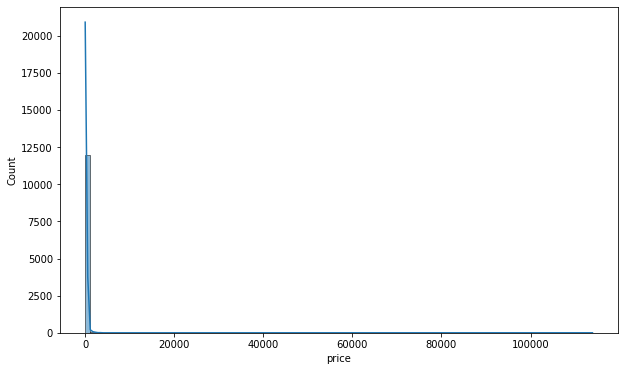

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df_eda["price"], bins=100, kde=True)

Rows dropped: 121

<Axes: xlabel='price', ylabel='Count'>

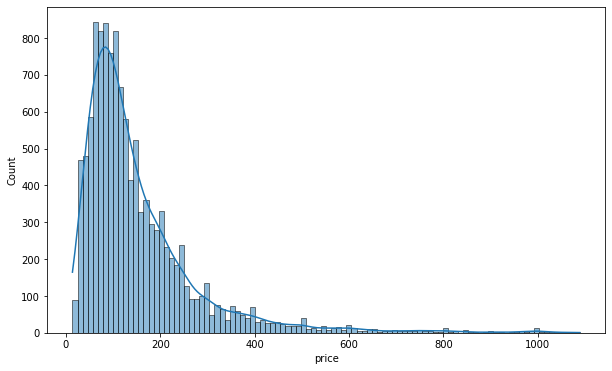

In [18]:
# Remove outliers (99th percentile)

rows_dropped = (
    df_eda.shape[0] - df_eda[df_eda["price"] <= df_eda["price"].quantile(0.99)].shape[0]
)

print(f"Rows dropped: {rows_dropped}")

df_eda = df_eda[df_eda["price"] <= df_eda["price"].quantile(0.99)]


plt.figure(figsize=(10, 6))
sns.histplot(df_eda["price"], bins=100, kde=True)

<Axes: xlabel='price', ylabel='Count'>

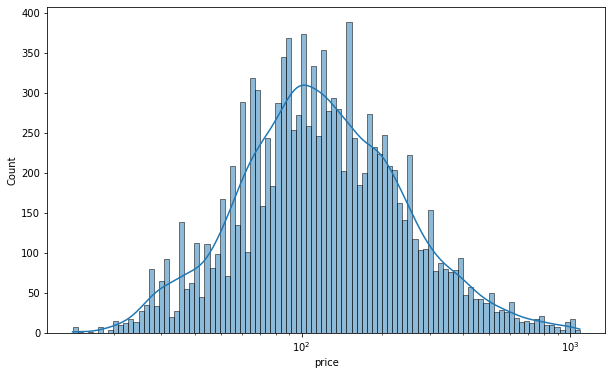

In [19]:
# Apply log transformation

plt.figure(figsize=(10, 6))
sns.histplot(df_eda["price"], bins=100, kde=True, log_scale=True)

The `log_price` target variable is much more normally distributed, and will be used for our analysis.


### Geographical insights


<Axes: xlabel='longitude', ylabel='latitude'>

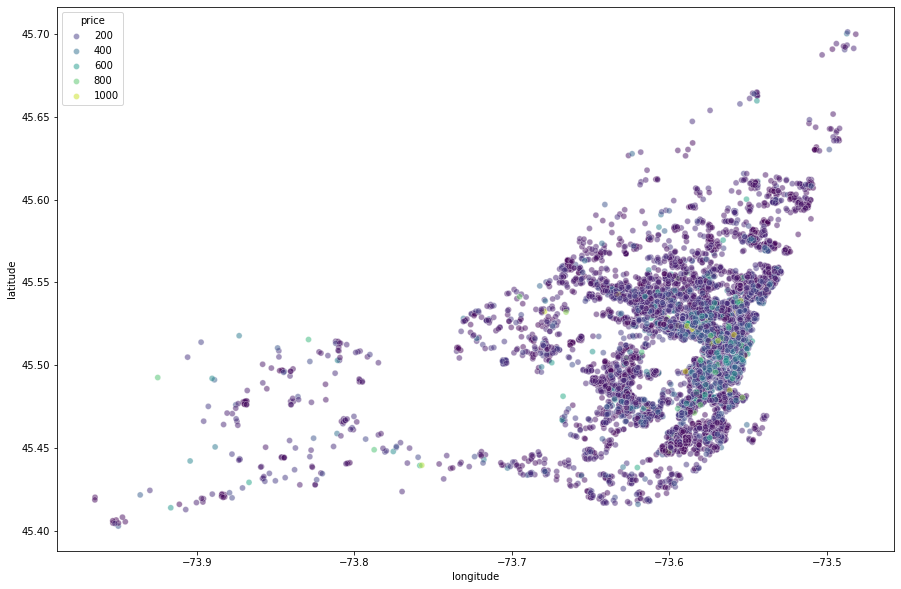

In [20]:
plt.figure(figsize=(15, 10))

sns.scatterplot(
    x="longitude",
    y="latitude",
    data=df_eda,
    hue="price",
    palette="viridis",
    alpha=0.5,
)

<ipython-input-21-b4a606367294>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-21-b4a606367294>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


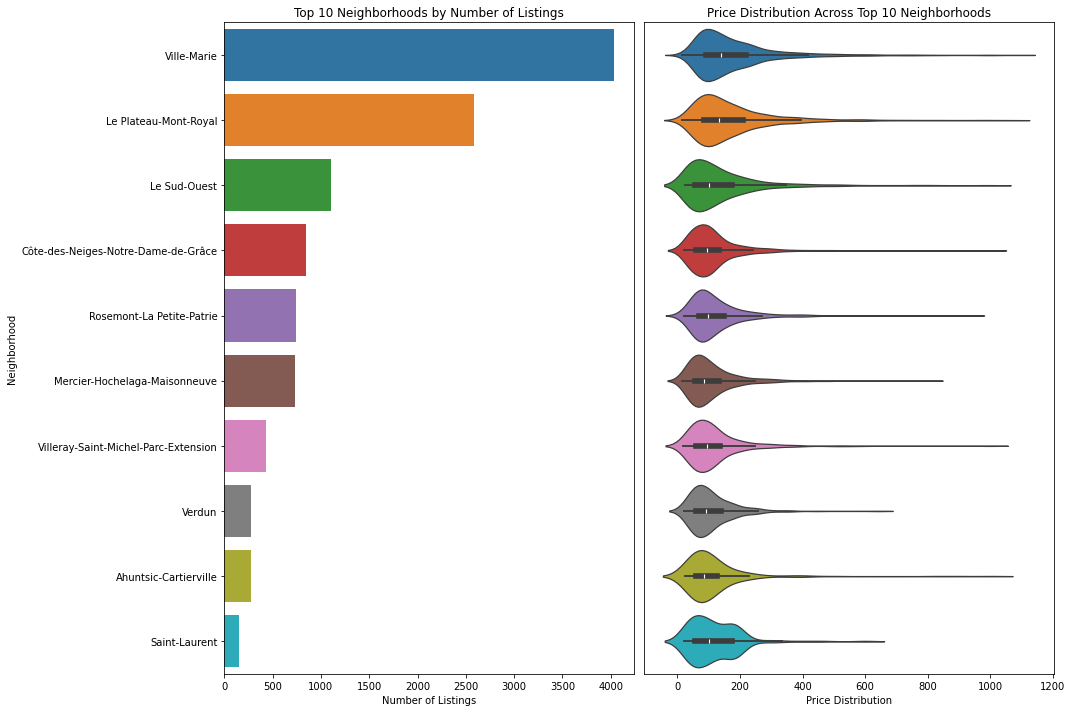

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

top_neighborhoods = df_eda["neighbourhood_cleansed"].value_counts().head(10)
order = top_neighborhoods.index
sns.barplot(
    ax=axes[0],
    y=top_neighborhoods.index,
    x=top_neighborhoods.values,
    palette="tab10",
)

axes[0].set_ylabel("Neighborhood")
axes[0].set_xlabel("Number of Listings")
axes[0].set_title("Top 10 Neighborhoods by Number of Listings")

sns.violinplot(
    ax=axes[1],
    y="neighbourhood_cleansed",
    x="price",
    data=df_eda[
        df_eda["neighbourhood_cleansed"].isin(top_neighborhoods.index)
    ].sort_values(by="neighbourhood_cleansed"),
    order=order,
    palette="tab10",
)

axes[1].set_ylabel("")
axes[1].set_yticks([])
axes[1].set_xlabel("Price Distribution")
axes[1].set_title("Price Distribution Across Top 10 Neighborhoods")

plt.tight_layout()
plt.show()

### Correlation matrix


In [22]:
corr_matrix = df_eda.corr(numeric_only=True)

In [23]:
corr_matrix["price"].abs().sort_values(ascending=False)


price                          1.000000
accommodates                   0.505835
bedrooms                       0.443114
beds                           0.433998
availability_30                0.111706
minimum_nights                 0.110832
host_acceptance_rate           0.086060
reviews_per_month              0.085528
availability_60                0.076301
longitude                      0.072625
instant_bookable               0.070252
review_scores_location         0.054458
availability_90                0.053049
host_id                        0.052788
number_of_reviews_ltm          0.044385
review_scores_checkin          0.038592
number_of_reviews_l30d         0.037548
availability_365               0.031854
latitude                       0.030580
review_scores_cleanliness      0.029061
has_availability               0.027818
host_is_superhost              0.017600
review_scores_communication    0.017106
host_has_profile_pic           0.016325
review_scores_accuracy         0.015736

A basic correlation matrix shows that the most important predictors for `price` are the number of people that can be accomodaetd, the number of bedrooms/beds, and the host's acceptance rate.



array([[<Axes: xlabel='price', ylabel='price'>,
        <Axes: xlabel='accommodates', ylabel='price'>,
        <Axes: xlabel='bedrooms', ylabel='price'>,
        <Axes: xlabel='beds', ylabel='price'>,
        <Axes: xlabel='availability_30', ylabel='price'>,
        <Axes: xlabel='minimum_nights', ylabel='price'>,
        <Axes: xlabel='number_of_reviews', ylabel='price'>],
       [<Axes: xlabel='price', ylabel='accommodates'>,
        <Axes: xlabel='accommodates', ylabel='accommodates'>,
        <Axes: xlabel='bedrooms', ylabel='accommodates'>,
        <Axes: xlabel='beds', ylabel='accommodates'>,
        <Axes: xlabel='availability_30', ylabel='accommodates'>,
        <Axes: xlabel='minimum_nights', ylabel='accommodates'>,
        <Axes: xlabel='number_of_reviews', ylabel='accommodates'>],
       [<Axes: xlabel='price', ylabel='bedrooms'>,
        <Axes: xlabel='accommodates', ylabel='bedrooms'>,
        <Axes: xlabel='bedrooms', ylabel='bedrooms'>,
        <Axes: xlabel='beds', yla

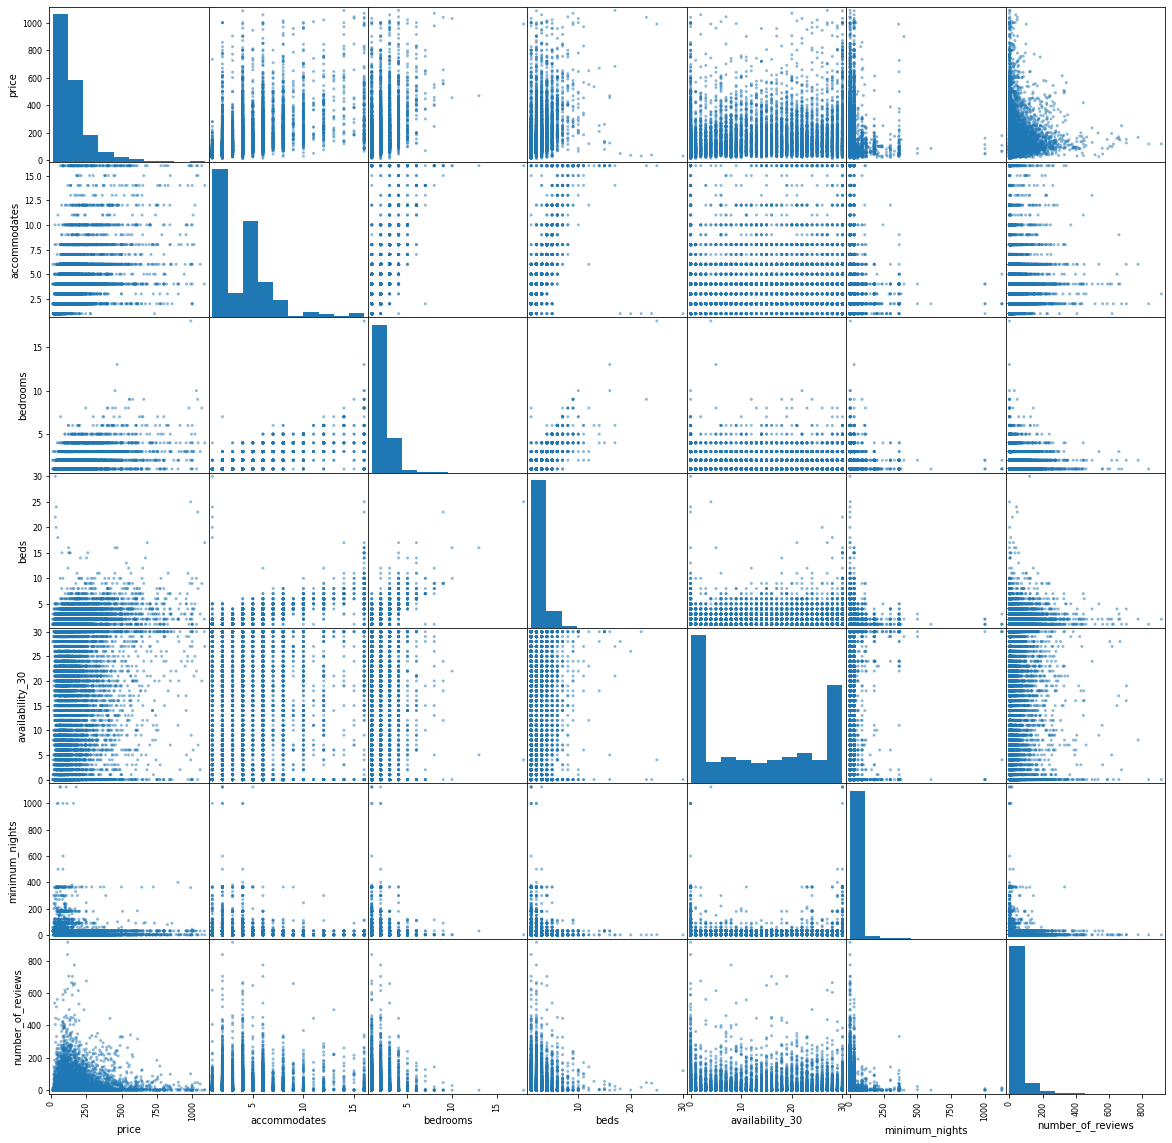

In [24]:
pd.plotting.scatter_matrix(
    df_eda[
        [
            "price",
            "accommodates",
            "bedrooms",
            "beds",
            "availability_30",
            "minimum_nights",
            "number_of_reviews",
        ]
    ],
    figsize=(20, 20),
)

# Preparing the data for modelling


### Data cleaning


In [25]:
# Remove outliers on target variable (99th percentile)
df_clean = df_clean[df_clean["price"] <= df_clean["price"].quantile(0.99)]

In [26]:
null_rows_idx = df_clean.isnull().any(axis=1)
df_clean[null_rows_idx].head()

,id,source,name,description,neighborhood_overview,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,29059,city scrape,Rental unit in Montreal · ★4.67 · 1 bedroom · ...,NaN,NaN,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,"Montreal, Canada",Voyageuse dans l'âme j'aime parcourir le monde...,within an hour,1.00,0.98,False,Downtown Montreal,2,2,"['phone', 'work_email']",True,True,NaN,Ville-Marie,45.51939,-73.56482,Entire rental unit,Entire home/apt,4,1 bath,1.0,2.0,"[""Extra pillows and blankets"", ""Free street pa...",173.0,2,60,True,27,50,74,316,436,47,0,2010-06-20,2023-10-23,4.67,4.79,4.62,4.81,4.76,4.81,4.68,False,2.67
1,29061,city scrape,Home in Montreal · ★4.72 · 2 bedrooms · 2 beds...,NaN,NaN,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,"Montreal, Canada",Voyageuse dans l'âme j'aime parcourir le monde...,within an hour,1.00,0.98,False,Downtown Montreal,2,2,"['phone', 'work_email']",True,True,NaN,Ville-Marie,45.51929,-73.56493,Entire home,Entire home/apt,4,1 bath,2.0,2.0,"[""Extra pillows and blankets"", ""Free street pa...",320.0,3,21,True,0,0,0,0,127,18,1,2012-02-23,2023-11-13,4.72,4.85,4.65,4.87,4.81,4.87,4.73,False,0.89
2,34715,city scrape,Rental unit in Montreal · ★4.90 · 2 bedrooms ·...,NaN,NaN,149769,https://www.airbnb.com/users/show/149769,Alain,2010-06-22,"Montreal, Canada",Patricia et moi-même aimons rencontrer de nouv...,within a few hours,1.00,1.00,False,La Petite-Patrie,1,1,"['email', 'phone']",True,True,NaN,Rosemont-La Petite-Patrie,45.53818,-73.60360,Entire rental unit,Entire home/apt,4,1 bath,2.0,3.0,"[""Washer"", ""Free street parking"", ""Children\u2...",160.0,31,31,True,24,42,72,121,11,2,1,2010-11-14,2023-11-14,4.90,4.90,5.00,5.00,5.00,4.70,4.90,False,0.07
3,36301,city scrape,Rental unit in Montréal · ★4.88 · 1 bedroom · ...,NaN,The neighborhood is very lively while the stre...,381468,https://www.airbnb.com/users/show/381468,Sylvie,2011-02-07,"Montreal, Canada",Hope you enjoy this wonderfully lively yet pea...,within a few hours,1.00,0.86,True,Le Plateau,8,11,"['email', 'phone']",True,True,"Montréal, Québec, Canada",Le Plateau-Mont-Royal,45.53026,-73.58413,Entire rental unit,Entire home/apt,2,1 bath,NaN,2.0,"[""First aid kit"", ""Fire extinguisher"", ""Microw...",175.0,32,730,True,1,24,53,53,49,4,0,2015-05-25,2023-08-31,4.88,4.92,4.86,4.92,4.90,4.88,4.78,False,0.47
4,38118,city scrape,Rental unit in Montreal · ★4.50 · 3 bedrooms ·...,NaN,NaN,163569,https://www.airbnb.com/users/show/163569,M.,2010-07-11,"Montreal, Canada",From Montreal.,a few days or more,0.43,0.00,False,Ville-Marie,2,3,"['email', 'phone']",True,True,NaN,Ville-Marie,45.52699,-73.55840,Private room in rental unit,Private room,1,1 shared bath,NaN,4.0,"[""Washer"", ""Free street parking"", ""Oven"", ""Dis...",50.0,31,60,True,30,57,87,362,16,0,0,2011-08-20,2022-08-29,4.50,4.56,4.25,4.81,4.81,4.63,4.38,False,0.11


In [27]:
df_clean.isnull().sum().sort_values(ascending=False) / len(df_clean) * 100


description                    69.759278
host_neighbourhood             63.080909
host_about                     50.208960
neighborhood_overview          49.573721
neighbourhood                  49.573721
bedrooms                       30.357740
host_location                  27.298562
reviews_per_month              20.971247
first_review                   20.971247
last_review                    20.971247
review_scores_cleanliness      20.929455
review_scores_rating           20.929455
review_scores_accuracy         20.929455
review_scores_checkin          20.929455
review_scores_communication    20.929455
review_scores_location         20.929455
review_scores_value            20.929455
host_response_time             14.242728
host_response_rate             14.242728
host_acceptance_rate            9.060515
beds                            1.287195
bathrooms_text                  0.091942
availability_60                 0.000000
has_availability                0.000000
instant_bookabl

As we can see, there are a lot of missing values in the dataset. For columns that have more than 25% missing values, we will drop them. Further, rows with the missing target variable will also be dropped.

**For the rest, we will impute the missing values with the median.**


In [28]:
cols_to_drop_missing = [
    "bedrooms",
    "description",
    "host_neighbourhood",
    "neighborhood_overview",
    "neighbourhood",
    "host_about",
    "host_location",
]

df_clean = df_clean.drop(cols_to_drop_missing, axis=1)

In [29]:
df_clean = df_clean.dropna(subset=["price"])

In [30]:
df_clean.isnull().sum().sort_values(ascending=False) / len(df_clean) * 100


reviews_per_month              20.971247
first_review                   20.971247
last_review                    20.971247
review_scores_value            20.929455
review_scores_location         20.929455
review_scores_communication    20.929455
review_scores_checkin          20.929455
review_scores_cleanliness      20.929455
review_scores_accuracy         20.929455
review_scores_rating           20.929455
host_response_time             14.242728
host_response_rate             14.242728
host_acceptance_rate            9.060515
beds                            1.287195
bathrooms_text                  0.091942
host_is_superhost               0.000000
number_of_reviews               0.000000
number_of_reviews_ltm           0.000000
number_of_reviews_l30d          0.000000
host_verifications              0.000000
host_total_listings_count       0.000000
host_listings_count             0.000000
host_has_profile_pic            0.000000
availability_90                 0.000000
host_since     

### Handling text and categorical variables


In [31]:
df_clean

,id,source,name,host_id,host_url,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,beds,amenities,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month
0,29059,city scrape,Rental unit in Montreal · ★4.67 · 1 bedroom · ...,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,within an hour,1.00,0.98,False,2,2,"['phone', 'work_email']",True,True,Ville-Marie,45.519390,-73.564820,Entire rental unit,Entire home/apt,4,1 bath,2.0,"[""Extra pillows and blankets"", ""Free street pa...",173.0,2,60,True,27,50,74,316,436,47,0,2010-06-20,2023-10-23,4.67,4.79,4.62,4.81,4.76,4.81,4.68,False,2.67
1,29061,city scrape,Home in Montreal · ★4.72 · 2 bedrooms · 2 beds...,125031,https://www.airbnb.com/users/show/125031,Maryline,2010-05-14,within an hour,1.00,0.98,False,2,2,"['phone', 'work_email']",True,True,Ville-Marie,45.519290,-73.564930,Entire home,Entire home/apt,4,1 bath,2.0,"[""Extra pillows and blankets"", ""Free street pa...",320.0,3,21,True,0,0,0,0,127,18,1,2012-02-23,2023-11-13,4.72,4.85,4.65,4.87,4.81,4.87,4.73,False,0.89
2,34715,city scrape,Rental unit in Montreal · ★4.90 · 2 bedrooms ·...,149769,https://www.airbnb.com/users/show/149769,Alain,2010-06-22,within a few hours,1.00,1.00,False,1,1,"['email', 'phone']",True,True,Rosemont-La Petite-Patrie,45.538180,-73.603600,Entire rental unit,Entire home/apt,4,1 bath,3.0,"[""Washer"", ""Free street parking"", ""Children\u2...",160.0,31,31,True,24,42,72,121,11,2,1,2010-11-14,2023-11-14,4.90,4.90,5.00,5.00,5.00,4.70,4.90,False,0.07
3,36301,city scrape,Rental unit in Montréal · ★4.88 · 1 bedroom · ...,381468,https://www.airbnb.com/users/show/381468,Sylvie,2011-02-07,within a few hours,1.00,0.86,True,8,11,"['email', 'phone']",True,True,Le Plateau-Mont-Royal,45.530260,-73.584130,Entire rental unit,Entire home/apt,2,1 bath,2.0,"[""First aid kit"", ""Fire extinguisher"", ""Microw...",175.0,32,730,True,1,24,53,53,49,4,0,2015-05-25,2023-08-31,4.88,4.92,4.86,4.92,4.90,4.88,4.78,False,0.47
4,38118,city scrape,Rental unit in Montreal · ★4.50 · 3 bedrooms ·...,163569,https://www.airbnb.com/users/show/163569,M.,2010-07-11,a few days or more,0.43,0.00,False,2,3,"['email', 'phone']",True,True,Ville-Marie,45.526990,-73.558400,Private room in rental unit,Private room,1,1 shared bath,4.0,"[""Washer"", ""Free street parking"", ""Oven"", ""Dis...",50.0,31,60,True,30,57,87,362,16,0,0,2011-08-20,2022-08-29,4.50,4.56,4.25,4.81,4.81,4.63,4.38,False,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12080,909238166863943561,city scrape,Rental unit in Montreal · ★New · Studio · 1 be...,34931002,https://www.airbnb.com/users/show/34931002,Elian,2015-06-03,within an hour,0.99,0.91,False,7,22,"['email', 'phone']",True,True,Le Plateau-Mont-Royal,45.523211,-73.576661,Entire rental unit,Entire home/apt,2,1 bath,1.0,"[""Wifi"", ""Kitchen"", ""Free washer \u2013 In uni...",89.0,2,365,True,2,20,38,38,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
12081,909437161890203684,city scrape,Rental unit in Montréal · ★New · 1 bedroom · 2...,24656852,https://www.airbnb.com/users/show/24656852,Yasmine,2014-12-09,NaN,NaN,NaN,False,1,3,"['email', 'phone']",True,True,Ville-Marie,45.538191,-73.556726,Entire rental unit,Entire home/apt,5,1 bath,2.0,"[""Baby bath - available upon request"", ""C

In [32]:
df_clean.select_dtypes(include="object").columns


Index(['id', 'source', 'name', 'host_url', 'host_name', 'host_response_time',
       'host_verifications', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms_text', 'amenities'],
      dtype='object')

In [33]:
df_clean[
    [
        "host_response_time",
        "host_verifications",
        "neighbourhood_cleansed",
        "property_type",
        "room_type",
        "amenities",
        "bathrooms_text",
    ]
].sample(10)


,host_response_time,host_verifications,neighbourhood_cleansed,property_type,room_type,amenities,bathrooms_text
2893,within an hour,"['email', 'phone', 'work_email']",Mercier-Hochelaga-Maisonneuve,Entire rental unit,Entire home/apt,"[""Extra pillows and blankets"", ""Free street pa...",1 bath
4691,NaN,"['email', 'phone']",Le Sud-Ouest,Entire loft,Entire home/apt,"[""Lockbox"", ""Kitchen"", ""Record player"", ""Sound...",1 bath
3780,within an hour,"['email', 'phone']",Ville-Marie,Entire rental unit,Entire home/apt,"[""Washer"", ""Hot water kettle"", ""Shampoo"", ""Ove...",1 bath
11689,within an hour,"['email', 'phone', 'work_email']",Ville-Marie,Entire condo,Entire home/apt,"[""Hot tub"", ""Freezer"", ""Free dryer \u2013 In u...",2 baths
6461,within an hour,['phone'],Le Sud-Ouest,Entire rental unit,Entire home/apt,"[""Washer"", ""TV"", ""Dedicated workspace"", ""BBQ g...",1 bath
9806,within an hour,"['email', 'phone']",Le Sud-Ouest,Entire rental unit,Entire home/apt,"[""Wifi"", ""Single level home"", ""Clothing storag...",1 bath
11122,NaN,"['email', 'phone']",Côte-des-Neiges-Notre-Dame-de-Grâce,Private room in condo,Private room,"[""Mosquito net"", ""Freezer"", ""Essentials"", ""Roo...",1 private bath
7329,within an hour,"['email', 'phone']",Ville-Marie,Entire rental unit,Entire home/apt,"[""Extra pillows and blankets"", ""Washer"", ""Free...",1 bath
6901,within an hour,"['email', 'phone', 'work_email']",Ville-Marie,Entire rental unit,Entire home/apt,"[""Washer"", ""Free dryer \u2013 In unit"", ""Hot w...",1 bath
8495,within an hour,"['email', 'phone']",Ville-Marie,Entire rental unit,Entire home/apt,"[""Wifi"", ""Cleaning products"", ""Electric stove""...",1 bath


#### Extracting `bathrooms` from `bathrooms_text`


In [34]:
def extract_bathrooms(bathrooms_text):
    """
    Extract the number of bathrooms from the `bathrooms_text` column.
    If it is a shared bathroom, we divide the number of bathrooms by 2.
    """
    if isinstance(bathrooms_text, str):
        bathrooms = re.search(r"(\d+)", bathrooms_text)
        if bathrooms:
            bathrooms = float(bathrooms.group(1))
            if "shared" in bathrooms_text:
                return bathrooms / 2
            return bathrooms
    return np.nan


df_clean["bathrooms"] = df_clean["bathrooms_text"].apply(extract_bathrooms)
df_clean["bathrooms"] = df_clean["bathrooms"].astype(float)

In [35]:
df_clean[["bathrooms", "bathrooms_text"]]

,bathrooms,bathrooms_text
0,1.0,1 bath
1,1.0,1 bath
2,1.0,1 bath
3,1.0,1 bath
4,0.5,1 shared bath
...,...,...
12080,1.0,1 bath
12081,1.0,1 bath
12082,2.0,2.5 baths
12083,1.0,1 bath


In [36]:
df_clean = df_clean.drop("bathrooms_text", axis=1)

### Converting amenities to a list


In [37]:
def extract_amenities(amenities):
    """
    Extract the amenities from the `amenities` column and convert them to lowercase.
    """
    amenities = amenities.replace("[", "").replace("]", "").replace('"', "").lower()
    return amenities.split(", ")


df_clean["amenities"] = df_clean["amenities"].apply(extract_amenities)

### Cleaning `property_type` and `room_type`


In [38]:
df_clean.groupby("room_type")["property_type"].value_counts().to_frame()

property_type
room_type       property_type                                    
Entire home/apt Entire rental unit                           7318
                Entire condo                                 1315
                Entire home                                   391
                Entire loft                                   377
                Entire serviced apartment                     181
                Entire townhouse                              141
                Room in aparthotel                             39
                Entire guest suite                             37
                Entire bungalow                                21
                Entire cottage                                 14
                Entire villa                                   11
                Entire guesthouse                              10
                Entire vacation home                            9
                Camper/RV                                       6
                Castle                                          6
                Boat                                            3
                Entire place                                    3
                Entire chalet                                   2
                Religious building                              2
                Tower                                           2
                Casa particular                                 1
                Cave                                            1
                Entire bed and breakfast                        1
                Entire cabin                                    1
                Room in boutique hotel                          1
                Tiny home                                       1
Hotel room      Room in aparthotel                             12
                Room in hostel                                  3
Private room    Private room in rental unit                  1124
                Private room in home                          344
                Private room in condo                         159
                Room in hotel                                  93
                Room in boutique hotel                         63
                Private room in townhouse                      47
                Private room in bed and breakfast              41
                Private room in hostel                         36
                Private room in bungalow                       24
                Private room in loft                           20
                Private room in guest suite                    17
                Private room in guesthouse                      8
                Private room in serviced apartment              5
                Private room in villa                           5
                Private room                                    3
                Private room in cottage                         3
                Private room in casa particular                 1
                Private room in minsu                           1
                Private room in nature lodge                    1
                Private room in vacation home                   1
Shared room     Shared room in hostel                          39
                Shared room in rental unit                      8
                Shared room in home                             6
                Shared room in hotel                            5
                Shared room in condo                            1

There are a lot of different property types and room types. To make the analysis simpler, we will drop `property_type` and only keep `room_type`.


In [39]:
df_clean = df_clean.drop("property_type", axis=1)

## Splitting the data into train and test


In [40]:
X = df_clean.drop("price", axis=1)
y = df_clean["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8374, 45), (8374,), (3590, 45), (3590,))

# Data transformation & feature engineering


In [41]:
X_train.select_dtypes(include="number").columns


Index(['host_id', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'beds', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month',
       'bathrooms'],
      dtype='object')

In [42]:
X_train.select_dtypes(include="object").columns


Index(['id', 'source', 'name', 'host_url', 'host_name', 'host_response_time',
       'host_verifications', 'neighbourhood_cleansed', 'room_type',
       'amenities'],
      dtype='object')

In [43]:
X_train.select_dtypes(exclude=["number", "object"]).columns


Index(['host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'has_availability', 'first_review',
       'last_review', 'instant_bookable'],
      dtype='object')

In [44]:
cols_to_drop_final = [
    "host_id",
    "id",
    "source",
    "name",
    "host_url",
    "host_name",
    "host_verifications",
    "first_review",
    "last_review",
]

### Numerical features


#### Average review score


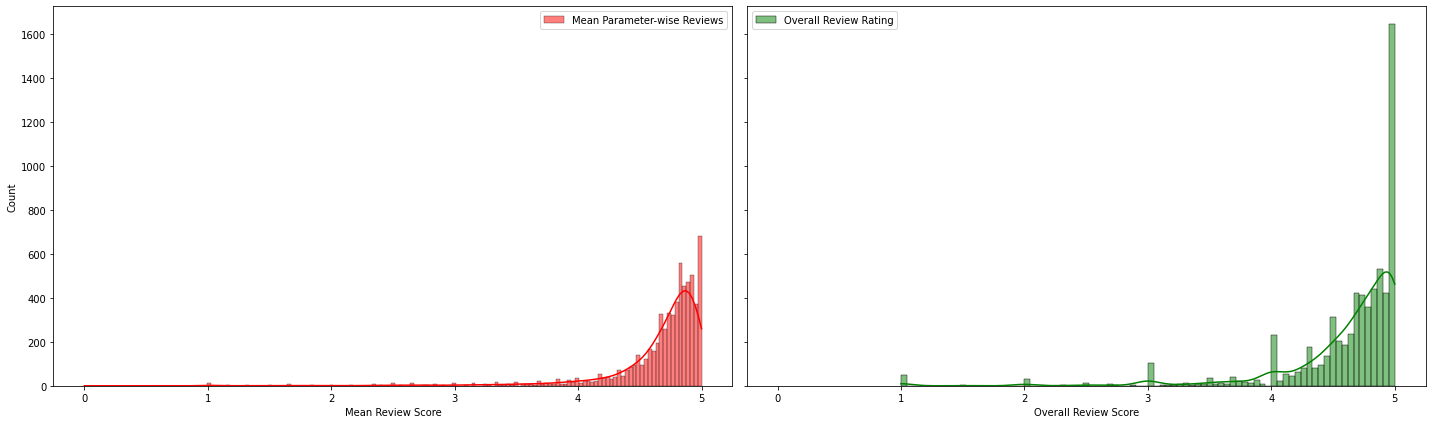

In [45]:
review_columns = [
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]

fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True, sharex=True)

sns.histplot(
    X_train[review_columns].mean(axis=1),
    kde=True,
    color="red",
    label="Mean Parameter-wise Reviews",
    ax=axs[0],
)
sns.histplot(
    X_train["review_scores_rating"],
    kde=True,
    color="green",
    label="Overall Review Rating",
    ax=axs[1],
)

axs[0].set_xlabel("Mean Review Score")
axs[0].set_ylabel("Count")
axs[0].legend()

axs[1].set_xlabel("Overall Review Score")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()

In [46]:
pd.DataFrame(
    [X_train[review_columns].mean(axis=1), X_train["review_scores_rating"]],
    index=["mean", "overall"],
).T.corr()


,mean,overall
mean,1.000000,0.926036
overall,0.926036,1.000000


Since the overall review rating and parameter-wise rating are highly correlated, we will use the parameter-wise rating since it provides a more accurate picture of the property.


In [47]:
cols_to_drop_final.append("review_scores_rating")

#### Host listings and total listings


In [48]:
X_train[["host_listings_count", "host_total_listings_count"]].corr()

,host_listings_count,host_total_listings_count
host_listings_count,1.000000,0.958186
host_total_listings_count,0.958186,1.000000


Since these two are highly correlated, we will only keep `host_total_listings_count`


In [49]:
cols_to_drop_final.append("host_listings_count")

#### Availability


In [50]:
X_train[
    ["availability_30", "availability_60", "availability_90", "availability_365"]
].corr()

,availability_30,availability_60,availability_90,availability_365
availability_30,1.000000,0.909322,0.822436,0.412070
availability_60,0.909322,1.000000,0.963381,0.514489
availability_90,0.822436,0.963381,1.000000,0.577517
availability_365,0.412070,0.514489,0.577517,1.000000


In [51]:
X_train[
    ["availability_30", "availability_60", "availability_90", "availability_365"]
].describe()

,availability_30,availability_60,availability_90,availability_365
count,8374.000000,8374.000000,8374.000000,8374.000000
mean,13.127657,29.838667,48.078099,160.501552
std,11.703361,22.348491,33.657947,126.811082
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,5.000000,12.000000,49.000000
50%,12.000000,31.000000,56.000000,140.000000
75%,25.000000,52.000000,80.000000,277.000000
max,30.000000,60.000000,90.000000,365.000000


We can keep columns to indicate recent availability and long-term availability, and drop the others, since they are highly correlated. We keep the `availability_30` and `availability_365` columns, which provides information about availability 30 days and 1 year in advance


In [52]:
cols_to_drop_final.extend(["availability_60", "availability_90"])

#### Number of reviews


In [53]:
X_train[["number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d"]].corr()

,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
number_of_reviews,1.000000,0.677079,0.388437
number_of_reviews_ltm,0.677079,1.000000,0.670770
number_of_reviews_l30d,0.388437,0.670770,1.000000


In [54]:
X_train[
    ["number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d"]
].describe()

,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
count,8374.000000,8374.000000,8374.000000
mean,30.878194,11.662407,0.950561
std,58.869173,18.789990,1.738539
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,8.000000,3.000000,0.000000
75%,35.000000,15.000000,1.000000
max,914.000000,203.000000,24.000000


Since these columns are not highly correlated, we can perform feature engineering and take the ratio of number of reviews in last 30 days to the to the number of reviews in last 12 months as a feature that indicates "Recent Popularity Index".``


In [55]:
cols_to_drop_final.extend(["number_of_reviews_ltm", "number_of_reviews_l30d"])

### Categorical features


In [56]:
X_train[
    [
        "host_response_time",
        "host_is_superhost",
        "host_verifications",
        "neighbourhood_cleansed",
        "room_type",
        "amenities",
        "has_availability",
    ]
]

,host_response_time,host_is_superhost,host_verifications,neighbourhood_cleansed,room_type,amenities,has_availability
7049,within an hour,True,['phone'],Le Plateau-Mont-Royal,Entire home/apt,"[coffee maker: french press, washer, free drye...",True
3366,within an hour,True,"['email', 'phone', 'work_email']",Ville-Marie,Entire home/apt,"[extra pillows and blankets, free street parki...",True
11961,within an hour,False,"['email', 'phone']",Ville-Marie,Entire home/apt,"[tv, wifi, washer, kitchen, air conditioning, ...",True
8657,within an hour,False,"['email', 'phone']",Le Plateau-Mont-Royal,Entire home/apt,"[wifi, cleaning products, shower gel, toaster,...",True
8402,within an hour,False,"['email', 'phone']",Ville-Marie,Entire home/apt,"[first aid kit, fire extinguisher, lockbox, mi...",True
...,...,...,...,...,...,...,...
11395,NaN,False,"['email', 'phone']",Le Plateau-Mont-Royal,Private room,"[washer, fire extinguisher, essentials, single...",True
5239,within an hour,False,"['email', 'phone']",Ville-Marie,Entire home/apt,"[extra pillows and blankets, washer, free drye...",True
5440,within an hour,False,"['email', 'phone', 'work_email']",Le Plateau-Mont-Royal,Entire home/apt,"[extra pillows and blankets, washer, hot water...",True
867,within an hour,True,"['email', 'phone']",Rosemont-La Petite-Patrie,Entire home/apt,"[extra pillows and blankets, washer, hot water...",True


#### Neighbourhood


In [57]:
X_train["neighbourhood_cleansed"].value_counts(normalize=True)


Ville-Marie                                 0.339623
Le Plateau-Mont-Royal                       0.211846
Le Sud-Ouest                                0.090279
Côte-des-Neiges-Notre-Dame-de-Grâce         0.072606
Rosemont-La Petite-Patrie                   0.062216
Mercier-Hochelaga-Maisonneuve               0.061022
Villeray-Saint-Michel-Parc-Extension        0.034989
Ahuntsic-Cartierville                       0.023525
Verdun                                      0.023048
Saint-Laurent                               0.013494
LaSalle                                     0.011225
Lachine                                     0.007284
Outremont                                   0.006210
Saint-Léonard                               0.005135
Pierrefonds-Roxboro                         0.004538
Anjou                                       0.004299
Westmount                                   0.004299
Rivière-des-Prairies-Pointe-aux-Trembles    0.003583
Pointe-Claire                               0

Since there a lot of neighbourhoods, we will instead opt for clustering listings based on their latitude/longitude using KMeans clustering.


In [58]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(
            self.n_clusters, n_init=10, random_state=self.random_state
        )
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

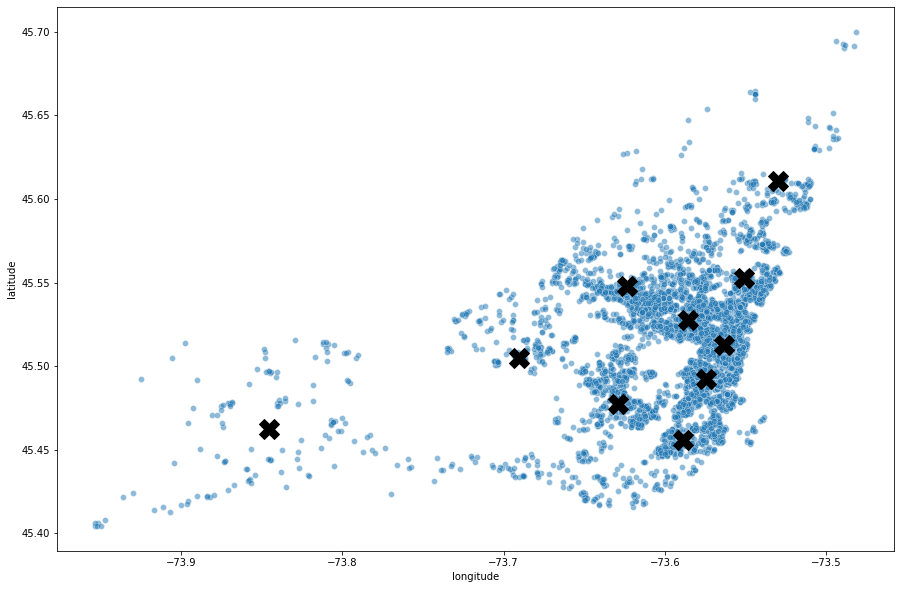

In [59]:
clusters_similarity = ClusterSimilarity(n_clusters=10, gamma=10.0, random_state=42)
similarities = clusters_similarity.fit_transform(X_train[["latitude", "longitude"]])

plt.figure(figsize=(15, 10))

sns.scatterplot(
    x="longitude",
    y="latitude",
    data=X_train,
    alpha=0.5,
)

plt.plot(
    clusters_similarity.kmeans_.cluster_centers_[:, 1],
    clusters_similarity.kmeans_.cluster_centers_[:, 0],
    linestyle="",
    color="black",
    marker="X",
    markersize=20,
    label="Cluster centres",
)

In [60]:
cols_to_drop_final.append("neighbourhood_cleansed")

#### Amenities


In [61]:
print(
    f'% of rows with no amenity: {(sum(X_train["amenities"].apply(lambda x: len(x)) <= 1) / len(X_train)):.2%}'
)

% of rows with no amenity: 0.14%

In [62]:
def join_amenities(amenities):
    return ",".join(amenities)


def extract_amenities(amenities):
    return amenities.split(",")


class AmenitiesFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, top_n=10):
        self.top_n = top_n
        self.vectorizer = None

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(
            preprocessor=join_amenities,
            tokenizer=extract_amenities,
            token_pattern=None,
            lowercase=True,
            binary=True,
            max_features=self.top_n,
        )
        self.vectorizer.fit(X)
        return self

    def transform(self, X):
        if self.vectorizer is None:
            raise NotFittedError(
                "This AmenitiesFeatureExtractor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator."
            )
        amenities_matrix = self.vectorizer.transform(X)
        return amenities_matrix.toarray()

    def get_feature_names_out(self, names=None):
        if self.vectorizer is None:
            raise NotFittedError(
                "This AmenitiesFeatureExtractor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator."
            )
        return self.vectorizer.get_feature_names_out()

In [63]:
amenities_extractor = AmenitiesFeatureExtractor(top_n=20)

amenity_df = pd.DataFrame(
    amenities_extractor.fit_transform(X_train["amenities"]),
    columns=amenities_extractor.get_feature_names_out(),
)

amenity_df.head()

,bed linens,cooking basics,dedicated workspace,dishes and silverware,essentials,hair dryer,hangers,heating,hot water,iron,kitchen,long term stays allowed,microwave,oven,refrigerator,shampoo,smoke alarm,tv,washer,wifi
0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,0
1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,1,0,0,1
2,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,0,1


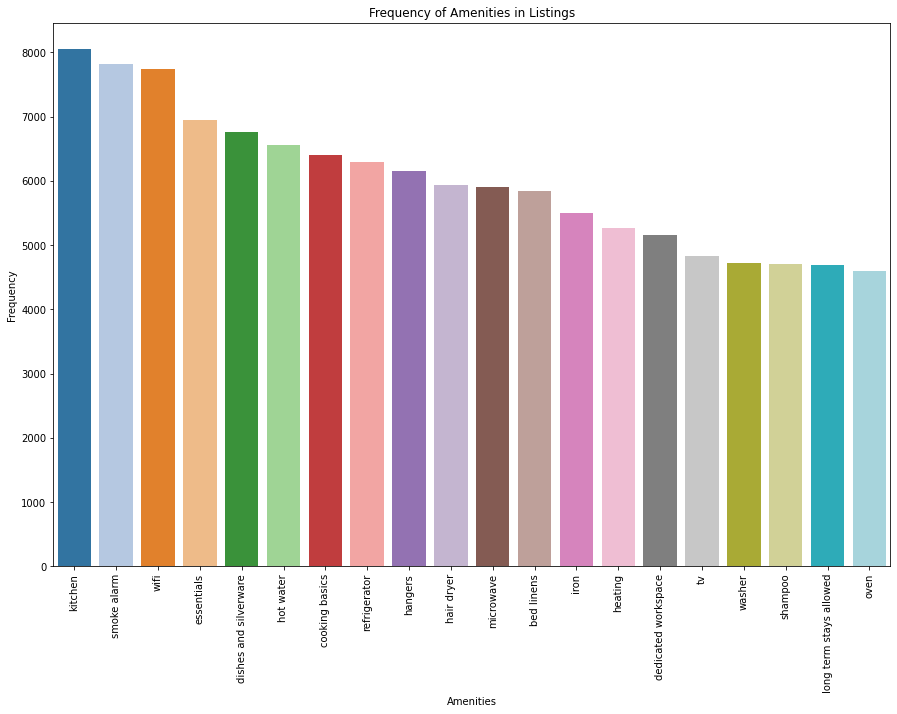

In [64]:
plt.figure(figsize=(15, 10))

sns.barplot(
    x=amenity_df.sum().sort_values(ascending=False).index,
    y=amenity_df.sum().sort_values(ascending=False).values,
    hue=amenity_df.sum().sort_values(ascending=False).index,
    palette="tab20",
)
plt.xticks(rotation=90)
plt.xlabel("Amenities")
plt.ylabel("Frequency")
plt.title("Frequency of Amenities in Listings")

plt.show()


Now that we have seen all the columns in our dataset and decided on the cleaning and feature engineering steps, we will wrap everything in a `Pipeline` object such that it can be applied to the training and testing data.

# Creating preprocessing pipelines


In [65]:
def column_ratio(X):
    return np.divide(
        X[:, [0]].astype(float),
        X[:, [1]].astype(float),
        out=np.zeros_like(X[:, [0]].astype(float)),
        where=X[:, [1]] != 0,
    )


def ratio_name(F, feature_names):
    return ["ratio"]


def mean_reviews_score_feature_name(F, feature_names):
    return ["mean_review_score_parameters"]


def mean_feature(X, axis):
    return np.nanmean(X, axis=axis).reshape(-1, 1)


def days_since_host(X):
    return (
        (np.datetime64("2024-01-01") - X)
        .astype("timedelta64[D]")
        .astype(float)
        .to_numpy()
        .reshape(-1, 1)
    )


def days_since_host_feature_name(F, feature_names):
    return ["days_since_host"]


average_review_score_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(
        mean_feature,
        kw_args={"axis": 1},
        validate=False,
        feature_names_out=mean_reviews_score_feature_name,
    ),
    StandardScaler(),
)

number_of_reviews_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(column_ratio, feature_names_out=ratio_name),
    StandardScaler(),
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")
)

days_since_host_pipeline = make_pipeline(
    FunctionTransformer(
        days_since_host, validate=False, feature_names_out=days_since_host_feature_name
    ),
    StandardScaler(),
)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [66]:
preprocessing = ColumnTransformer(
    [
        ("reviews", average_review_score_pipeline, review_columns),
        (
            "number_of_reviews",
            number_of_reviews_pipeline,
            ["number_of_reviews_ltm", "number_of_reviews_l30d"],
        ),
        (
            "neighbourhood",
            (ClusterSimilarity(n_clusters=10, gamma=10.0, random_state=42)),
            ["latitude", "longitude"],
        ),
        (
            "host_since",
            days_since_host_pipeline,
            ["host_since"],
        ),
        (
            "amenities",
            (AmenitiesFeatureExtractor(top_n=10)),
            "amenities",
        ),
        (
            "categorical",
            cat_pipeline,
            ["host_response_time", "room_type"],
        ),
        (
            "pass",
            "passthrough",
            [
                "host_has_profile_pic",
                "host_is_superhost",
                "host_identity_verified",
                "has_availability",
                "instant_bookable",
            ],
        ),
        ("drop", "drop", cols_to_drop_final),
    ],
    remainder=default_num_pipeline,
)

In [67]:
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_train_preprocessed.shape

(8374, 48)

In [68]:
feature_names = preprocessing.get_feature_names_out()
feature_names


array(['reviews__mean_review_score_parameters',
       'number_of_reviews__ratio', 'neighbourhood__Cluster 0 similarity',
       'neighbourhood__Cluster 1 similarity',
       'neighbourhood__Cluster 2 similarity',
       'neighbourhood__Cluster 3 similarity',
       'neighbourhood__Cluster 4 similarity',
       'neighbourhood__Cluster 5 similarity',
       'neighbourhood__Cluster 6 similarity',
       'neighbourhood__Cluster 7 similarity',
       'neighbourhood__Cluster 8 similarity',
       'neighbourhood__Cluster 9 similarity',
       'host_since__days_since_host', 'amenities__cooking basics',
       'amenities__dishes and silverware', 'amenities__essentials',
       'amenities__hair dryer', 'amenities__hangers',
       'amenities__hot water', 'amenities__kitchen',
       'amenities__refrigerator', 'amenities__smoke alarm',
       'amenities__wifi',
       'categorical__host_response_time_a few days or more',
       'categorical__host_response_time_within a day',
       'categorical

In [69]:
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('reviews',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function mean_reviews_score_feature_name at 0x00000262D235DB40>,
                                                                      fu...
                                 ['host_has_profile_pic', 'host_is_superhost',
                                  'host_identity_verified', 'has_availability',
                                  'instant_bookable']),
                                ('drop', 'drop',
                                 ['host_id', 'id', 'source', 'name', 'host_url',
                                  'host_name', 'host_verifications',
                                  'first_review', 'last_review',
                                  'review_scores_rating', 'host_listings_count',
                                  'availability_60', 'availability_90',
                                  'number_of_reviews_ltm',
                                  'number_of_reviews_l30d',
                                  'neighbourhood_cleansed'])])

# Select and Train a Model


In [70]:
y_train


7049     173.0
3366     129.0
11961    326.0
8657     160.0
8402     160.0
         ...  
11395     46.0
5239     133.0
5440     133.0
867      200.0
7335     105.0
Name: price, Length: 8374, dtype: float64

To normalize the target variable, we will use `TransformedTargetRegressor` to transform the target variable using the log function, and then fit the model.


In [71]:
class TransformedRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model=None):
        self.model = model
        self.transformer = TransformedTargetRegressor(
            regressor=self.model, func=np.log1p, inverse_func=np.expm1
        )

    def fit(self, X, y):
        self.transformer.fit(X, y)
        return self

    def predict(self, X):
        return self.transformer.predict(X)

    def score(self, X, y):
        return self.transformer.score(X, y)

    def set_params(self, **params):
        return super().set_params(**params)

    def get_params(self, deep=True):
        return super().get_params(deep=deep)

### Linear regression


In [72]:
lin_reg = make_pipeline(
    preprocessing,
    TransformedRegressor(LinearRegression()),
)

lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('reviews',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function mean_reviews_score...
                                                 ('drop', 'drop',
                                                  ['host_id', 'id', 'source',
                                                   'name', 'host_url',
                                                   'host_name',
                                                   'host_verifications',
                                                   'first_review',
                                                   'last_review',
                                                   'review_scores_rating',
                                                   'host_listings_count',
                                                   'availability_60',
                                                   'availability_90',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'neighbourhood_cleansed'])])),
                ('transformedregressor',
                 TransformedRegressor(model=LinearRegression()))])

In [73]:
lin_reg_predict = lin_reg.predict(X_train)
lin_reg_rmse = mean_squared_error(y_train, lin_reg_predict, squared=False)

print(
    f'Training RMSE for {lin_reg.named_steps["transformedregressor"].transformer.regressor_}: {lin_reg_rmse:.2f}'
)

Training RMSE for LinearRegression(): 108.87

### Decision tree


In [74]:
dt_reg = make_pipeline(
    preprocessing,
    TransformedRegressor(DecisionTreeRegressor(random_state=42)),
)

dt_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('reviews',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function mean_reviews_score...
                                                  ['host_id', 'id', 'source',
                                                   'name', 'host_url',
                                                   'host_name',
                                                   'host_verifications',
                                                   'first_review',
                                                   'last_review',
                                                   'review_scores_rating',
                                                   'host_listings_count',
                                                   'availability_60',
                                                   'availability_90',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'neighbourhood_cleansed'])])),
                ('transformedregressor',
                 TransformedRegressor(model=DecisionTreeRegressor(random_state=42)))])

In [75]:
dt_reg_predict = dt_reg.predict(X_train)
dt_reg_rmse = mean_squared_error(y_train, dt_reg_predict, squared=False)

print(
    f'Training RMSE for {dt_reg.named_steps["transformedregressor"].transformer.regressor_}: {dt_reg_rmse:.2f}'
)

Training RMSE for DecisionTreeRegressor(random_state=42): 0.00

### Random Forest


In [76]:
rf_reg = make_pipeline(
    preprocessing,
    TransformedRegressor(RandomForestRegressor(random_state=42, n_jobs=-1)),
)

rf_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('reviews',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function mean_reviews_score...
                                                  ['host_id', 'id', 'source',
                                                   'name', 'host_url',
                                                   'host_name',
                                                   'host_verifications',
                                                   'first_review',
                                                   'last_review',
                                                   'review_scores_rating',
                                                   'host_listings_count',
                                                   'availability_60',
                                                   'availability_90',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'neighbourhood_cleansed'])])),
                ('transformedregressor',
                 TransformedRegressor(model=RandomForestRegressor(n_jobs=-1,
                                                                  random_state=42)))])

In [77]:
rf_reg_predict = rf_reg.predict(X_train)
rf_reg_rmse = mean_squared_error(y_train, rf_reg_predict, squared=False)

print(
    f'Training RMSE for {rf_reg.named_steps["transformedregressor"].transformer.regressor_}: {rf_reg_rmse:.2f}'
)

Training RMSE for RandomForestRegressor(n_jobs=-1, random_state=42): 46.58

### Gradient Boosting


In [78]:
gb_reg = make_pipeline(
    preprocessing,
    TransformedRegressor(GradientBoostingRegressor(random_state=42)),
)

gb_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('reviews',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function mean_reviews_score...
                                                  ['host_id', 'id', 'source',
                                                   'name', 'host_url',
                                                   'host_name',
                                                   'host_verifications',
                                                   'first_review',
                                                   'last_review',
                                                   'review_scores_rating',
                                                   'host_listings_count',
                                                   'availability_60',
                                                   'availability_90',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'neighbourhood_cleansed'])])),
                ('transformedregressor',
                 TransformedRegressor(model=GradientBoostingRegressor(random_state=42)))])

In [79]:
gb_reg_predict = gb_reg.predict(X_train)
gb_reg_rmse = mean_squared_error(y_train, gb_reg_predict, squared=False)

print(
    f'Training RMSE for {gb_reg.named_steps["transformedregressor"].transformer.regressor_}: {gb_reg_rmse:.2f}'
)

Training RMSE for GradientBoostingRegressor(random_state=42): 95.28

### Cross-validation


In [80]:
def get_cross_val_scores(model, X, y, cv=10):
    scores = cross_val_score(
        model,
        X,
        y,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        verbose=2,
        n_jobs=-1,
    )
    return -scores


def print_model_performance(model, X_train, y_train, cv=10):
    cv_scores = get_cross_val_scores(model, X_train, y_train, cv=cv)
    train_rmse = mean_squared_error(y_train, model.predict(X_train), squared=False)

    print(
        f'Training RMSE for {model.named_steps["transformedregressor"].transformer.regressor_}: {train_rmse:.2f}'
    )
    print(
        f'Cross validation (n={cv}) RMSE for {model.named_steps["transformedregressor"].transformer.regressor_}: {cv_scores.mean():.2f} +/- {cv_scores.std():.2f}'
    )

    return cv_scores

In [81]:
print_model_performance(lin_reg, X_train, y_train)
print_model_performance(dt_reg, X_train, y_train)
print_model_performance(rf_reg, X_train, y_train, cv=5)
print_model_performance(gb_reg, X_train, y_train, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.8s finished


Training RMSE for LinearRegression(): 108.87

Cross validation (n=10) RMSE for LinearRegression(): 109.08 +/- 7.19

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.5s finished


Training RMSE for DecisionTreeRegressor(random_state=42): 0.00

Cross validation (n=10) RMSE for DecisionTreeRegressor(random_state=42): 131.29 +/- 5.08

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   28.4s remaining:   18.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished


Training RMSE for RandomForestRegressor(n_jobs=-1, random_state=42): 46.58

Cross validation (n=5) RMSE for RandomForestRegressor(n_jobs=-1, random_state=42): 96.37 +/- 5.45

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   10.9s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.1s finished


Training RMSE for GradientBoostingRegressor(random_state=42): 95.28

Cross validation (n=5) RMSE for GradientBoostingRegressor(random_state=42): 99.94 +/- 5.34


array([ 96.23594013,  97.11026724, 103.28115591, 108.77385004,
        94.29501297])

# Hyperparameter tuning using GridSearchCV


In [82]:
final_pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        (
            "regressor",
            TransformedRegressor(GradientBoostingRegressor(random_state=42)),
        ),
    ]
)

param_grid = {
    "preprocessing__neighbourhood__n_clusters": [5, 10, 15],
    "preprocessing__amenities__top_n": [10, 20, 30],
    "regressor__model__n_estimators": [100, 300, 500],
}

In [83]:
grid_search = GridSearchCV(
    final_pipeline,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=3,
)

grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('reviews',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<fu...
                                                                          'number_of_reviews_l30d',
                                                                          'neighbourhood_cleansed'])])),
                                       ('regressor',
                                        TransformedRegressor(model=GradientBoostingRegressor(random_state=42)))]),
             n_jobs=-1,
             param_grid={'preprocessing__amenities__top_n': [10, 20, 30],
                         'preprocessing__neighbourhood__n_clusters': [5, 10,
                                                                      15],
                         'regressor__model__n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [84]:
grid_search.best_params_


{
    'preprocessing__amenities__top_n': 30,
    'preprocessing__neighbourhood__n_clusters': 15,
    'regressor__model__n_estimators': 500
}

In [85]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('reviews',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function mean_reviews_score_fea...
                                                  ['host_id', 'id', 'source',
                                                   'name', 'host_url',
                                                   'host_name',
                                                   'host_verifications',
                                                   'first_review',
                                                   'last_review',
                                                   'review_scores_rating',
                                                   'host_listings_count',
                                                   'availability_60',
                                                   'availability_90',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'neighbourhood_cleansed'])])),
                ('regressor',
                 TransformedRegressor(model=GradientBoostingRegressor(n_estimators=500,
                                                                      random_state=42)))])

In [86]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    by="mean_test_score", ascending=False
)

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__amenities__top_n,param_preprocessing__neighbourhood__n_clusters,param_regressor__model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,76.311594,4.408107,0.050806,0.003559,30,15,500,"{'preprocessing__amenities__top_n': 30, 'prepr...",-92.434464,-91.955436,-97.482532,-103.584798,-89.670998,-95.025645,4.982129,1
11,43.306671,0.879023,0.096865,0.006524,20,5,500,"{'preprocessing__amenities__top_n': 20, 'prepr...",-93.615858,-90.913707,-97.343256,-104.685731,-88.727040,-95.057118,5.608058,2
20,45.871508,1.010394,0.099969,0.010534,30,5,500,"{'preprocessing__amenities__top_n': 30, 'prepr...",-93.261049,-90.533101,-97.950591,-104.686627,-89.160532,-95.118380,5.648773,3
2,42.218595,0.546484,0.094042,0.008203,10,5,500,"{'preprocessing__amenities__top_n': 10, 'prepr...",-93.623638,-91.855732,-97.340032,-104.593576,-89.547863,-95.392168,5.258328,4
23,72.054194,1.285319,0.096388,0.006577,30,10,500,"{'preprocessing__amenities__top_n': 30, 'prepr...",-92.583102,-92.720911,-97.595307,-104.561629,-90.049229,-95.502036,5.146765,5
17,96.540161,1.597288,0.100079,0.000027,20,15,500,"{'preprocessing__amenities__top_n': 20, 'prepr...",-93.144978,-92.303867,-98.039358,-104.761124,-89.794786,-95.608823,5.300347,6
8,94.202567,2.188906,0.100072,0.010573,10,15,500,"{'preprocessing__amenities__top_n': 10, 'prepr...",-93.339680,-93.168916,-96.595574,-104.147944,-91.221856,-95.694794,4.565106,7
5,66.958540,0.923472,0.096087,0.005849,10,10,500,"{'preprocessing__amenities__top_n': 10, 'prepr...",-93.291284,-92.571202,-98.110777,-104.034044,-90.567073,-95.714876,4.841596,8
14,71.149689,1.058118,0.088970,0.010284,20,10,500,"{'preprocessing__amenities__top_n': 20, 'prepr...",-93.240213,-92.169365,-98.188922,-105.767436,-90.004228,-95.874033,5.627687,9
19,27.428527,0.406159,0.086937,0.008355,30,5,300,"{'preprocessing__amenities__top_n': 30, 'prepr...",-93.332840,-92.404415,-99.303204,-105.456769,-90.535135,-96.206473,5.477868,10


In [87]:
final_model = grid_search.best_estimator_

final_feature_names = final_model.named_steps["preprocessing"].get_feature_names_out()

final_feature_importances = final_model.named_steps[
    "regressor"
].transformer.regressor_.feature_importances_


feature_importances_df = pd.DataFrame(
    {
        "feature": final_feature_names,
        "importance": final_feature_importances,
    }
).sort_values(by="importance", ascending=False)

feature_importances_df["feature"] = feature_importances_df["feature"].str.replace(
    ".*__", "", regex=True
)
feature_importances_df.round(3)

,feature,importance
64,accommodates,0.342
66,minimum_nights,0.093
52,room_type_Entire home/apt,0.091
2,Cluster 0 similarity,0.076
72,bathrooms,0.042
...,...,...
26,dishes and silverware,0.000
34,iron,0.000
27,essentials,0.000
44,toaster,0.000


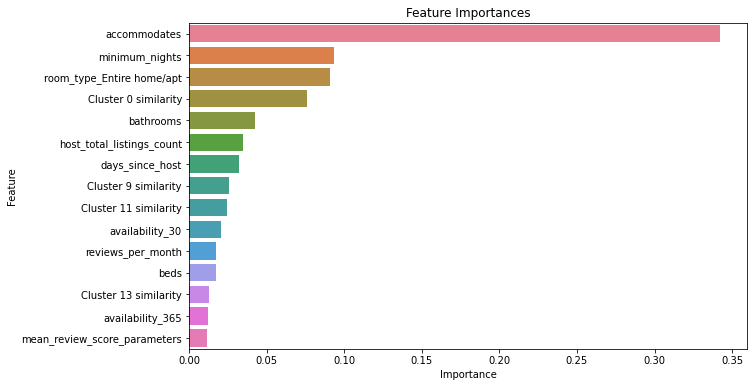

In [88]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=feature_importances_df.head(15),
    y="feature",
    x="importance",
    hue="feature",
)

plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Feature importances

The top features, in decreasing order of importance, are:
- **Accomodates**: The number of people that can be accomodated in the listing is the most important feature. This is intuitive, since the price of a listing should depend on the number of people that can stay in it.
- **Minimum nights**: The minimum number of nights that a guest can stay in the listing is the second most important feature. This is also intuitive, as listings that have a higher minimum number of nights are usually less expensive as they are more suitable for long-term stays.
- **Room type**: The type of room is the third most important feature. Listings that are entire homes/apartments tend to be more expensive than other type of rooms as they provide more privacy.
- **Cluster similarity**: The next most important feature is the location of the listing, which has been computed as the similarity to each cluster. In this particular case, the most important cluster is cluster 0, which is located in Ville-Marie (Downtown), where the most expensive listings are located.

# Evaluating the model on the test set


In [89]:
final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)

print(f"Final RMSE: {final_rmse:.2f}")

Final RMSE: 89.60

### Confidence interval


In [90]:
alpha = 0.95
squared_errors = (final_predictions - y_test) ** 2
ci = np.sqrt(
    stats.t.interval(
        alpha,
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors),
    )
)

ci

array([82.36111282, 96.30174017])

# Saving and loading the model


In [91]:
joblib.dump(final_model, "airbnb_price_prediction_model.pkl")

['airbnb_price_prediction_model.pkl']

In [92]:
model = joblib.load("airbnb_price_prediction_model.pkl")

In [93]:
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('reviews',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function mean_reviews_score_fea...
                                                  ['host_id', 'id', 'source',
                                                   'name', 'host_url',
                                                   'host_name',
                                                   'host_verifications',
                                                   'first_review',
                                                   'last_review',
                                                   'review_scores_rating',
                                                   'host_listings_count',
                                                   'availability_60',
                                                   'availability_90',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'neighbourhood_cleansed'])])),
                ('regressor',
                 TransformedRegressor(model=GradientBoostingRegressor(n_estimators=500,
                                                                      random_state=42)))])